#### Visualize the UMAP embeddings without batch correction and with harmony integration (from step 04) and also scVI (from step 05). Subsample the adata proportionally by cell type and donor_id, and save as csv for computing the LISI metric in script 06B. 

In [1]:
import scanpy as sc
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import gc

In [2]:
sc._settings.settings._vector_friendly=True

In [3]:
plots_dir = "../../paper_figures/"

In [4]:
%%time
adata = sc.read_h5ad("04_harmony_integrated_adata.h5ad")
adata

CPU times: user 21.9 s, sys: 1min 42s, total: 2min 4s
Wall time: 2min 4s


AnnData object with n_obs × n_vars = 2923936 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', 'leiden_harmony'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden_harmony', 'donor_id_colors', 'hvg', 'leiden_harmony', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'X_umap_no_harmony'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Plot without harmony integration

In [5]:
adata.obsm['X_umap'] = adata.obsm['X_umap_no_harmony']

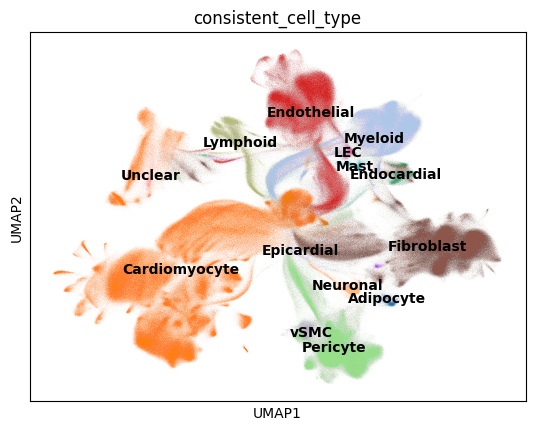

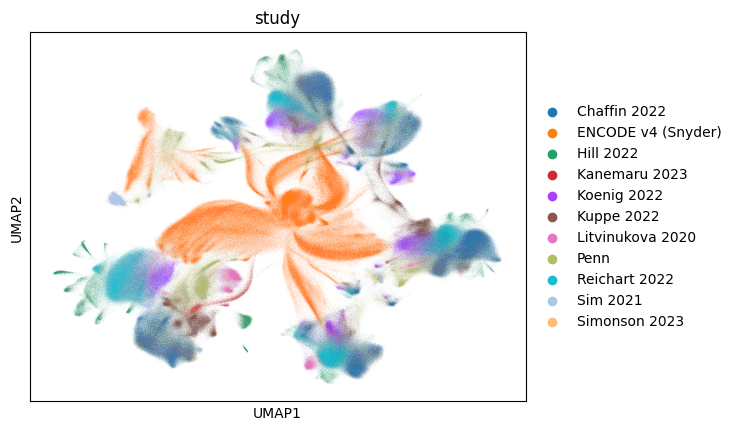

In [6]:
# plot UMAP embedding with cell type labels on data
with plt.rc_context():
    
    sc.pl.umap(adata, color = ["consistent_cell_type"], legend_loc = "on data", show = False)
    plt.savefig(plots_dir + "snRNA_UMAP_no_integration_by_cell_type.pdf", bbox_inches="tight")
    plt.show()

    # plot UMAP embedding with study labels of to the right
    sc.pl.umap(adata, color = ["study"], show = False)
    plt.savefig(plots_dir + "snRNA_UMAP_no_integration_by_study.pdf", bbox_inches="tight")
    plt.show()

### Plot with harmony integration

In [7]:
adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']

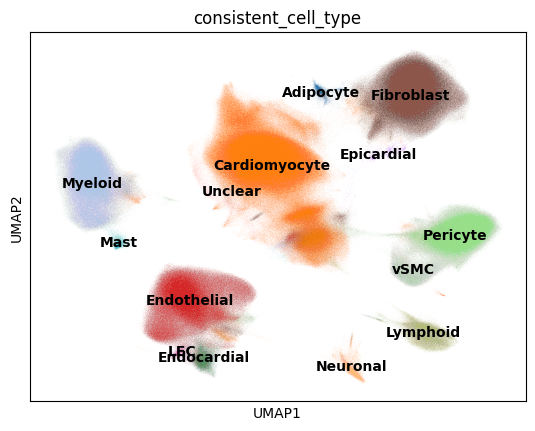

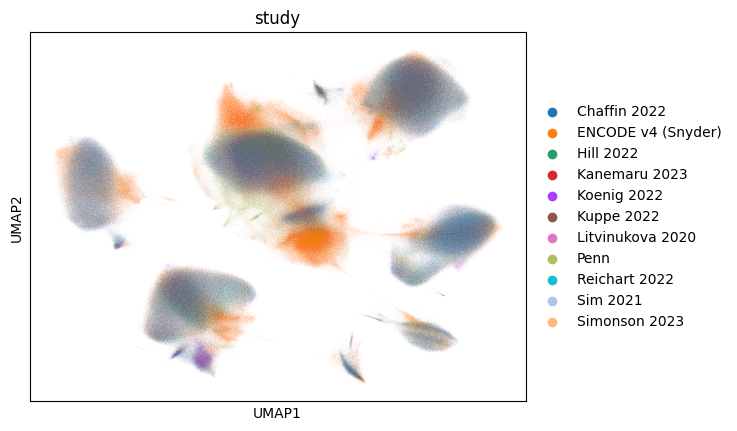

CPU times: user 2min, sys: 5.61 s, total: 2min 6s
Wall time: 2min 4s


In [8]:
%%time 

with plt.rc_context():

    # plot UMAP embedding with cell type labels on data
    sc.pl.umap(adata, color = ["consistent_cell_type"], legend_loc = "on data", show = False)
    plt.savefig(plots_dir + "snRNA_UMAP_harmony_by_cell_type.pdf", bbox_inches="tight")
    plt.show()

    # plot UMAP embedding with study labels of to the right
    sc.pl.umap(adata, color = ["study"], show = False)
    plt.savefig(plots_dir + "snRNA_UMAP_harmony_by_study.pdf", bbox_inches="tight")
    plt.show()

### We will now save the UMAP coordinates for the local inverse Simpson's index metric from the Harmony paper

In [9]:
umap_no_harmony_coords = adata.obsm['X_umap_no_harmony']
umap_harmony_coords = adata.obsm['X_umap_harmony']

adata.obs['umap_no_harmony_1'] = umap_no_harmony_coords[:, 0]
adata.obs['umap_no_harmony_2'] = umap_no_harmony_coords[:, 1]
adata.obs['umap_harmony_1'] = umap_harmony_coords[:, 0]
adata.obs['umap_harmony_2'] = umap_harmony_coords[:, 1]

In [10]:
adata_metadata = adata.obs

#### Likewise, load in the scVI adata from step 05A (before further processing in steps 05B onwards) and obtain the coordinates

In [11]:
%%time
scvi_adata = sc.read_h5ad("05_scvi_adata.h5ad")
scvi_adata

CPU times: user 22.1 s, sys: 5min 57s, total: 6min 19s
Wall time: 10min 7s


AnnData object with n_obs × n_vars = 2923936 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_leiden_scVI', 'hvg', 'leiden_scVI', 'leiden_scVI_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [12]:
umap_scvi_coords = scvi_adata.obsm['X_umap']

# add this to the original adata 
adata.obs['umap_scvi_1'] = umap_scvi_coords[:, 0]
adata.obs['umap_scvi_2'] = umap_scvi_coords[:, 1]

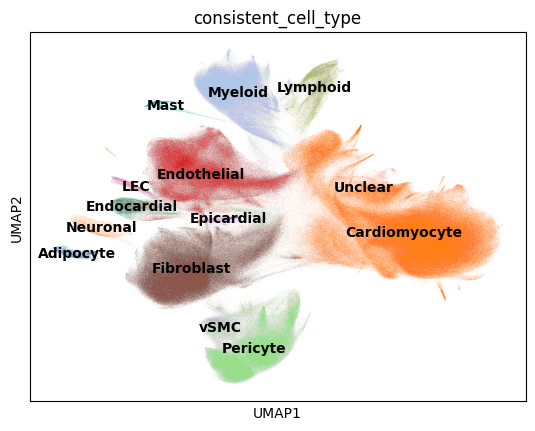

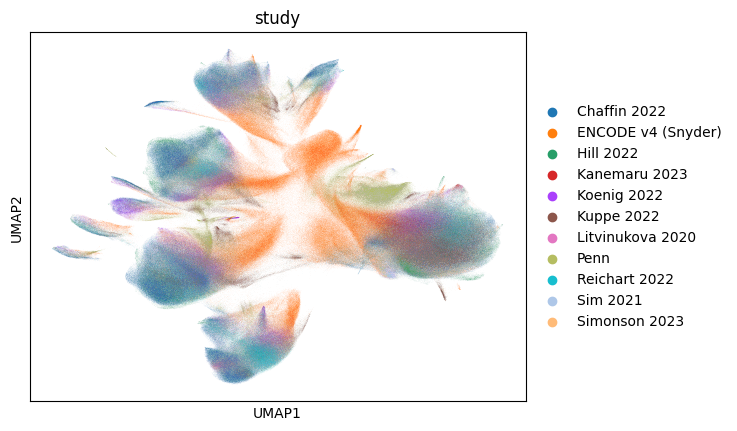

In [13]:
with plt.rc_context():
    # plot UMAP embedding with cell type labels on data
    sc.pl.umap(scvi_adata, color = ["consistent_cell_type"], legend_loc = "on data", show = False)
    plt.savefig(plots_dir + "snRNA_unfiltered_UMAP_scvi_by_cell_type.pdf", bbox_inches="tight")
    plt.show()

    # plot UMAP embedding with study labels of to the right
    sc.pl.umap(scvi_adata, color = ["study"], show = False)
    plt.savefig(plots_dir + "snRNA_unfiltered_UMAP_scvi_by_study.pdf", bbox_inches="tight")
    plt.show()

### Save the adata metadata for LISI computation

In [14]:
counts_per_study = adata_metadata.groupby("study").count()[['age']].rename(columns = {"age": "count"}).reset_index()
counts_per_study['prop'] = counts_per_study['count'] / counts_per_study['count'].sum()
counts_per_study = counts_per_study.sort_values(by = "count").reset_index(drop=True)
counts_per_study

/mnt/data1/william/tmp/ipykernel_3131217/1025858153.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_per_study = adata_metadata.groupby("study").count()[['age']].rename(columns = {"age": "count"}).reset_index()


,study,count,prop
0,Kanemaru 2023,31657,0.010827
1,Sim 2021,42991,0.014703
2,Litvinukova 2020,88413,0.030238
3,Simonson 2023,99049,0.033875
4,Hill 2022,112443,0.038456
5,Kuppe 2022,181446,0.062055
6,Koenig 2022,217552,0.074404
7,Penn,219120,0.074940
8,Reichart 2022,456757,0.156213
9,Chaffin 2022,591161,0.202180


In [15]:
adata_metadata.columns

Index(['age', 'donor_id', 'sex', 'region', 'cell_type', 'disease',
       'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei',
       'barcode', 'sample_id', 'age_status', 'tech_plus_study',
       'disease_binary', 'decade', 'age_group', 'leiden_harmony',
       'umap_no_harmony_1', 'umap_no_harmony_2', 'umap_harmony_1',
       'umap_harmony_2', 'umap_scvi_1', 'umap_scvi_2'],
      dtype='object')

#### Subsample this proportionally to 5% of the adata, since LISI will want the number of cells per study to be similar

In [16]:
def sample_cells_proportionally_by_donor_id_and_cell_type(adata_metadata, 
                                                          target_cells,
                                                          cell_type_key, 
                                                          donor_key,
                                                          random_state = None,
                                                          inverse_proportional=False):

    '''Sample cells proportionally per cell type using the adata.obs metadata. The goal is to get roughly equal
    sampling per donor (based on donor_key) and cell type (based on cell_type_key) and to obtain in (target_cells) number of cells'''

    # determine number of cells to sample per cell type proportionally
    total_cells = len(adata_metadata)
    cell_type_counts = adata_metadata[cell_type_key].value_counts()

    # if inversely proportional, then sample the adata.obs inversely to the overall cell count in the larger adata_metadata
    if inverse_proportional:
        inverse_counts = 1 / cell_type_counts
        normalized_inverse_counts = inverse_counts / inverse_counts.sum()
        cell_type_target_counts = (normalized_inverse_counts * target_cells).astype(int)
    else:
        cell_type_proportions = cell_type_counts / total_cells
        cell_type_target_counts =  (cell_type_proportions * target_cells).astype(int)
    
    # create list to store sampled indices
    sampled_indices = []
    
    # sample from each donor and cell type proportionally (or inversely)
    for cell_type, count in cell_type_target_counts.items():
        cell_type_df = adata_metadata[adata_metadata[cell_type_key] == cell_type]
        donors = cell_type_df[donor_key].unique()
        
        # get roughly equal sampling per donor
        cells_per_study = max(count // len(donors), 1)  # minimum of 1 cell per study
        for donor in donors:
            donor_df = cell_type_df[cell_type_df[donor_key] == donor]
            sample_count = min(len(donor_df), cells_per_study)
            
            # randomly sample without replacement
            sampled_indices.extend(donor_df.sample(n=sample_count, replace=False, random_state=random_state).index)
    
    # create sampled metadata df
    sampled_metadata = adata_metadata.loc[sampled_indices]
    
    # final downsampling to target_cells if oversampled
    if len(sampled_metadata) > target_cells:
        sampled_metadata = sampled_metadata.sample(n=target_cells, replace=False)
    
    return sampled_metadata

In [17]:
%%time
# subsample adata and use the random size 42
subsampled_adata_metadata = sample_cells_proportionally_by_donor_id_and_cell_type(adata_metadata = adata.obs, 
                                                                            donor_key = "donor_id",
                                                                            cell_type_key = "consistent_cell_type",
                                                                            target_cells = adata.obs.shape[0] * 0.05, 
                                                                            random_state = 42, 
                                                                           inverse_proportional=False).copy()

CPU times: user 5.55 s, sys: 159 ms, total: 5.71 s
Wall time: 5.71 s


In [18]:
Counter(subsampled_adata_metadata.consistent_cell_type)

Counter({'Cardiomyocyte': 54668,
         'Fibroblast': 28696,
         'Endothelial': 21486,
         'Pericyte': 16016,
         'Myeloid': 12782,
         'Lymphoid': 3449,
         'Endocardial': 1409,
         'vSMC': 1404,
         'Neuronal': 1168,
         'Unclear': 600,
         'Mast': 490,
         'LEC': 484,
         'Adipocyte': 431,
         'Epicardial': 244})

In [19]:
len(subsampled_adata_metadata.study.unique())

11

In [20]:
# drop the unclear labelled cells
subsampled_adata_metadata = subsampled_adata_metadata[subsampled_adata_metadata['consistent_cell_type'] != "Unclear"].copy()

In [21]:
subsampled_adata_metadata.shape

(142727, 24)

In [ ]:
subsampled_adata_metadata.to_csv("06_adata_metadata_for_LISI.csv")